In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Dataset, WeightedRandomSampler
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import xml.etree.ElementTree as ET
import glob

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
batch_size = 32
num_epochs = 50
learning_rate = 0.0002
weight_decay = 5e-4 

Using device: cuda


In [3]:
class TsinghuaDogsDataset(Dataset):
    def __init__(self, image_root, annotation_root, transform=None):
        self.image_root = image_root
        self.annotation_root = annotation_root
        self.transform = transform
        
        # Getting all image paths
        self.image_paths = []
        self.labels = []
        self.classes = []
        
        # Parsing folder structure to get image paths and breed labels
        breed_folders = [f for f in os.listdir(image_root) if os.path.isdir(os.path.join(image_root, f))]
        
        print(f"Found {len(breed_folders)} breed folders")
        
        for breed_idx, breed_folder in enumerate(sorted(breed_folders)):
            breed_path = os.path.join(image_root, breed_folder)
            
            # Extract breed name from folder
            if '-' in breed_folder:
                breed_name = breed_folder.split('-')[2]
            else:
                breed_name = breed_folder
                
            self.classes.append(breed_name)
            
            # Finding all images for this breed (including in subfolders)
            image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
            images = []
            
            # Walk through all subfolders
            for root, _, files in os.walk(breed_path):
                for file in files:
                    if any(file.lower().endswith(ext) for ext in image_extensions):
                        images.append(os.path.join(root, file))
            
            print(f"Breed {breed_name}: found {len(images)} images")
            
            for img_path in images:
                self.image_paths.append(img_path)
                self.labels.append(breed_idx)
        
        print(f"Total: {len(self.image_paths)} images across {len(self.classes)} dog breeds")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [4]:
# Define data transforms with stronger augmentation
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),  # Increased rotation
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),  # Stronger color jitter
    transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(0.8, 1.2)),  # More distortion
    transforms.RandomGrayscale(p=0.15),  # Increased probability
    transforms.RandomPerspective(distortion_scale=0.3, p=0.6),  # Increased distortion and probability
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.2))  # Increased probability and scale
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# Data loading
image_dir = "/kaggle/input/tsinghua-dogs/low-resolution/low-resolution" 
annotation_dir = "/kaggle/input/tsinghua-dogs/low-annotations/Low-Annotations" 

# Creating dataset
full_dataset = TsinghuaDogsDataset(image_root=image_dir, annotation_root=annotation_dir, transform=train_transform)

# Splitting into train and validation sets (80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply different transforms to each split
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = test_transform

Found 130 breed folders
Breed Shiba_Dog: found 1043 images
Breed French_bulldog: found 1121 images
Breed Siberian_husky: found 1160 images
Breed malamute: found 1324 images
Breed Pomeranian: found 1936 images
Breed Airedale: found 200 images
Breed miniature_poodle: found 200 images
Breed affenpinscher: found 200 images
Breed schipperke: found 201 images
Breed Australian_terrier: found 202 images
Breed Welsh_springer_spaniel: found 202 images
Breed curly_coated_retriever: found 202 images
Breed Staffordshire_bullterrier: found 203 images
Breed Norwich_terrier: found 203 images
Breed Tibetan_terrier: found 203 images
Breed English_setter: found 203 images
Breed Norfolk_terrier: found 203 images
Breed Pembroke: found 205 images
Breed Tibetan_mastiff: found 205 images
Breed Border_terrier: found 206 images
Breed Great_Dane: found 206 images
Breed Scotch_terrier: found 206 images
Breed flat_coated_retriever: found 206 images
Breed Saluki: found 206 images
Breed Irish_setter: found 207 image

In [6]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Get number of classes and print dataset information
num_classes = len(full_dataset.classes)
print(f"Total number of images: {len(full_dataset)}")
print(f"Number of classes: {num_classes}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

Total number of images: 70432
Number of classes: 130
Training set size: 56345
Validation set size: 14087


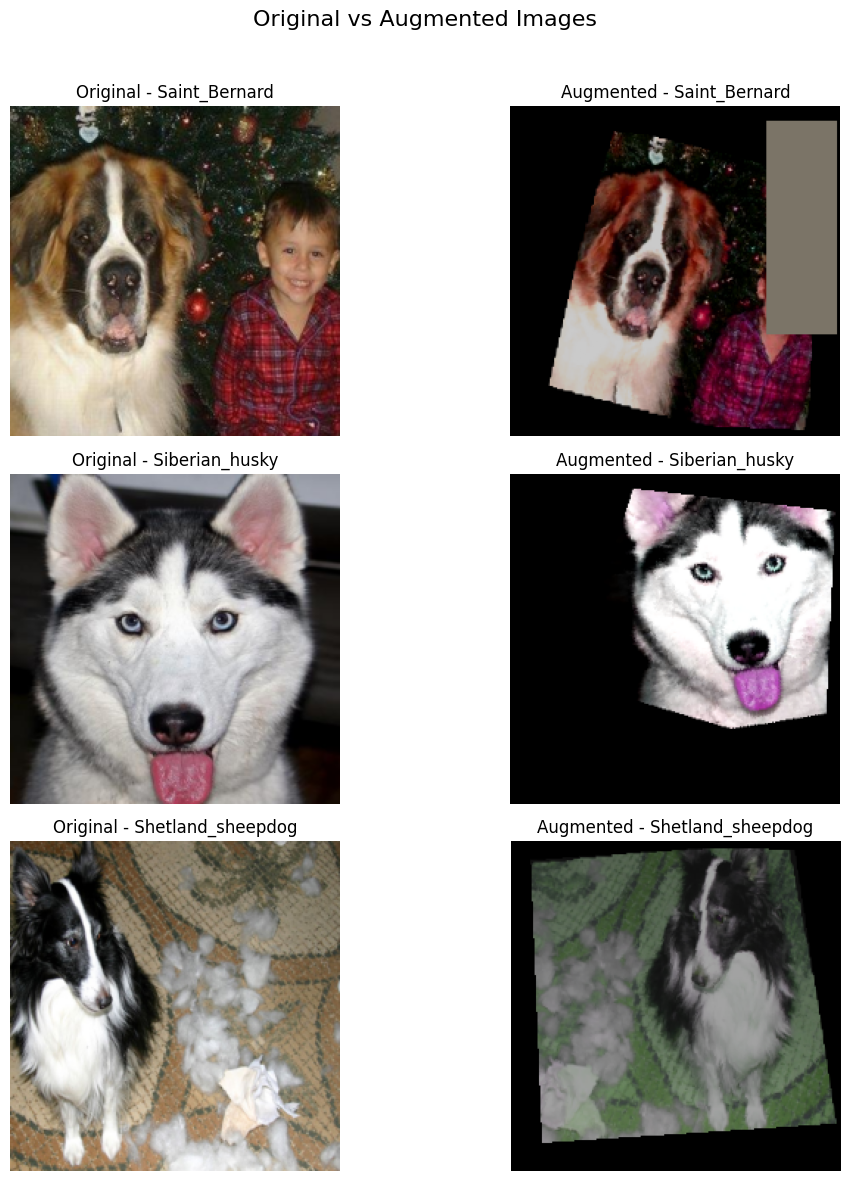

In [19]:
# Add this code after creating your dataset but before training
# This will display original and augmented versions of a few images

import matplotlib.pyplot as plt
import torch
import random
import numpy as np

# Helper function to denormalize and convert tensor to numpy image
def tensor_to_image(tensor):
    # Denormalize
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor * std + mean
    # Convert to numpy and transpose to (H,W,C) format
    img = tensor.numpy().transpose(1, 2, 0)
    # Clip values to ensure they're in valid range
    img = np.clip(img, 0, 1)
    return img

# Use the test_transform you already defined as the "basic" transform
# This avoids creating a redundant transform

# Select 3 random images to visualize
random.seed(42)  # For reproducible results
indices = random.sample(range(len(full_dataset)), 3)

# Plot the images
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
plt.tight_layout()

for i, idx in enumerate(indices):
    # Get image path
    img_path = full_dataset.image_paths[idx]
    original_img = Image.open(img_path).convert('RGB')
    
    # Get breed name
    breed_idx = full_dataset.labels[idx]
    breed_name = full_dataset.classes[breed_idx]
    
    # Create basic version (without augmentation) 
    basic_tensor = test_transform(original_img)
    basic_image = tensor_to_image(basic_tensor)
    
    # Create augmented version
    augmented_tensor = train_transform(original_img)
    augmented_image = tensor_to_image(augmented_tensor)
    
    # Display images
    axs[i, 0].imshow(basic_image)
    axs[i, 0].set_title(f"Original - {breed_name}")
    axs[i, 0].axis('off')
    
    axs[i, 1].imshow(augmented_image)
    axs[i, 1].set_title(f"Augmented - {breed_name}")
    axs[i, 1].axis('off')

plt.suptitle("Original vs Augmented Images", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [8]:
# Defining the Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_rate=0.2):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(dropout_rate)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        
        return out

In [9]:
class DogBreedCNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(DogBreedCNN, self).__init__()
        self.dropout_rate = dropout_rate
        
        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Residual blocks with dropout
        self.layer1 = self._make_layer(64, 64, 2, dropout_rate=0.1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2, dropout_rate=0.15)
        self.layer3 = self._make_layer(128, 256, 2, stride=2, dropout_rate=0.2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2, dropout_rate=0.25)
        
        # Global average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(512, num_classes)
        
        # Initialize weights
        self._initialize_weights()
        
    def _make_layer(self, in_channels, out_channels, blocks, stride=1, dropout_rate=0.2):
        layers = []
        
        # First block with potential downsampling
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        layers.append(ResidualBlock(in_channels, out_channels, stride, downsample, dropout_rate))
        
        # Remaining blocks
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels, dropout_rate=dropout_rate))
        
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

# Initializing the model
model = DogBreedCNN(num_classes, dropout_rate=0.6).to(device)

In [10]:
# Setting up loss, optimizer and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

In [11]:
# Mixup data augmentation function
def mixup_data(x, y, alpha=0.2):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [12]:
# Training the model
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, 
                         mixup_alpha=0.2, patience=5, grad_accum_steps=1):
    best_val_acc = 0.0
    early_stop_counter = 0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        optimizer.zero_grad()  # Zero gradients at the beginning of epoch
        
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for batch_idx, (inputs, labels) in enumerate(progress_bar):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Apply mixup
            inputs_mixed, targets_a, targets_b, lam = mixup_data(inputs, labels, mixup_alpha)
            
            # Forward pass
            outputs = model(inputs_mixed)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            
            # Scale loss by accumulation steps
            loss = loss / grad_accum_steps
            loss.backward()
            
            # Gradient accumulation
            if (batch_idx + 1) % grad_accum_steps == 0:
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                optimizer.zero_grad()
            
            # Calculate statistics
            running_loss += loss.item() * inputs.size(0) * grad_accum_steps
            
            # Calculate accuracy on original inputs (not mixed)
            with torch.no_grad():
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            # Update progress bar
            progress_bar.set_postfix({"loss": loss.item() * grad_accum_steps, "accuracy": 100 * correct / total})
        
        # Handle any remaining accumulated gradients
        if len(train_loader) % grad_accum_steps != 0:
            optimizer.step()
            optimizer.zero_grad()
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = 100 * correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            progress_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # Update progress bar
                progress_bar.set_postfix({"loss": loss.item(), "accuracy": 100 * correct / total})
        
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = 100 * correct / total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)
        
        # Update learning rate scheduler
        scheduler.step()
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f} Train Acc: {epoch_train_acc:.2f}%")
        print(f"Val Loss: {epoch_val_loss:.4f} Val Acc: {epoch_val_acc:.2f}%")
        print(f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}")
        
        # Save the best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), 'best_dog_breed_model.pth')
            print(f"Model saved with validation accuracy: {best_val_acc:.2f}%")
            early_stop_counter = 0  # Reset counter if improved
        else:
            early_stop_counter += 1
            print(f"No improvement for {early_stop_counter} epochs.")
        
        # Early stopping check
        if early_stop_counter >= patience:
            print(f"No improvement for {patience} epochs. Early stopping.")
            break
    
    return train_losses, val_losses, train_accuracies, val_accuracies

In [13]:
# Train the model with advanced techniques
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs,
    mixup_alpha=0.5, patience=7, grad_accum_steps=2
)

Epoch 1/50 [Val]: 100%|██████████| 441/441 [01:15<00:00,  5.88it/s, loss=3.41, accuracy=21.9]


Epoch 1/50
Train Loss: 3.8201 Train Acc: 16.16%
Val Loss: 3.3740 Val Acc: 21.89%
Learning Rate: 0.000200
Model saved with validation accuracy: 21.89%


Epoch 2/50 [Val]: 100%|██████████| 441/441 [00:41<00:00, 10.72it/s, loss=3.34, accuracy=26.7]


Epoch 2/50
Train Loss: 3.5428 Train Acc: 23.00%
Val Loss: 3.0379 Val Acc: 26.73%
Learning Rate: 0.000199
Model saved with validation accuracy: 26.73%


Epoch 3/50 [Val]: 100%|██████████| 441/441 [00:39<00:00, 11.09it/s, loss=2.99, accuracy=30.9]


Epoch 3/50
Train Loss: 3.3825 Train Acc: 27.49%
Val Loss: 2.8386 Val Acc: 30.86%
Learning Rate: 0.000198
Model saved with validation accuracy: 30.86%


Epoch 4/50 [Val]: 100%|██████████| 441/441 [00:40<00:00, 10.79it/s, loss=2.62, accuracy=33.5]


Epoch 4/50
Train Loss: 3.2644 Train Acc: 30.32%
Val Loss: 2.6642 Val Acc: 33.48%
Learning Rate: 0.000197
Model saved with validation accuracy: 33.48%


Epoch 5/50 [Val]: 100%|██████████| 441/441 [00:41<00:00, 10.75it/s, loss=2.52, accuracy=33.8]


Epoch 5/50
Train Loss: 3.1788 Train Acc: 32.83%
Val Loss: 2.5827 Val Acc: 33.77%
Learning Rate: 0.000195
Model saved with validation accuracy: 33.77%


Epoch 6/50 [Val]: 100%|██████████| 441/441 [00:42<00:00, 10.34it/s, loss=2.28, accuracy=38.7]


Epoch 6/50
Train Loss: 3.0832 Train Acc: 35.36%
Val Loss: 2.4151 Val Acc: 38.72%
Learning Rate: 0.000193
Model saved with validation accuracy: 38.72%


Epoch 7/50 [Val]: 100%|██████████| 441/441 [00:40<00:00, 10.80it/s, loss=1.86, accuracy=41.1]


Epoch 7/50
Train Loss: 3.0069 Train Acc: 37.49%
Val Loss: 2.3147 Val Acc: 41.07%
Learning Rate: 0.000191
Model saved with validation accuracy: 41.07%


Epoch 8/50 [Val]: 100%|██████████| 441/441 [00:40<00:00, 10.96it/s, loss=1.51, accuracy=43.1]


Epoch 8/50
Train Loss: 2.9161 Train Acc: 39.82%
Val Loss: 2.1724 Val Acc: 43.15%
Learning Rate: 0.000188
Model saved with validation accuracy: 43.15%


Epoch 9/50 [Val]: 100%|██████████| 441/441 [00:40<00:00, 11.00it/s, loss=1.94, accuracy=45.6]


Epoch 9/50
Train Loss: 2.8387 Train Acc: 41.82%
Val Loss: 2.0665 Val Acc: 45.59%
Learning Rate: 0.000185
Model saved with validation accuracy: 45.59%


Epoch 10/50 [Val]: 100%|██████████| 441/441 [00:40<00:00, 10.76it/s, loss=1.77, accuracy=48.1]


Epoch 10/50
Train Loss: 2.7770 Train Acc: 43.90%
Val Loss: 1.9886 Val Acc: 48.07%
Learning Rate: 0.000181
Model saved with validation accuracy: 48.07%


Epoch 11/50 [Val]: 100%|██████████| 441/441 [00:40<00:00, 10.81it/s, loss=1.73, accuracy=48.6]


Epoch 11/50
Train Loss: 2.7059 Train Acc: 46.09%
Val Loss: 1.9264 Val Acc: 48.64%
Learning Rate: 0.000177
Model saved with validation accuracy: 48.64%


Epoch 12/50 [Val]: 100%|██████████| 441/441 [00:40<00:00, 10.95it/s, loss=1.61, accuracy=51.8]


Epoch 12/50
Train Loss: 2.6757 Train Acc: 47.76%
Val Loss: 1.8240 Val Acc: 51.81%
Learning Rate: 0.000173
Model saved with validation accuracy: 51.81%


Epoch 13/50 [Val]: 100%|██████████| 441/441 [00:40<00:00, 10.78it/s, loss=1.37, accuracy=50.8]


Epoch 13/50
Train Loss: 2.5901 Train Acc: 49.61%
Val Loss: 1.8427 Val Acc: 50.76%
Learning Rate: 0.000169
No improvement for 1 epochs.


Epoch 14/50 [Val]: 100%|██████████| 441/441 [00:40<00:00, 10.86it/s, loss=1.22, accuracy=54]   


Epoch 14/50
Train Loss: 2.5465 Train Acc: 51.31%
Val Loss: 1.7047 Val Acc: 54.01%
Learning Rate: 0.000164
Model saved with validation accuracy: 54.01%


Epoch 15/50 [Val]: 100%|██████████| 441/441 [00:41<00:00, 10.54it/s, loss=1.15, accuracy=54.8] 


Epoch 15/50
Train Loss: 2.5343 Train Acc: 53.07%
Val Loss: 1.6789 Val Acc: 54.75%
Learning Rate: 0.000159
Model saved with validation accuracy: 54.75%


Epoch 16/50 [Val]: 100%|██████████| 441/441 [00:41<00:00, 10.69it/s, loss=1.2, accuracy=55.3]  


Epoch 16/50
Train Loss: 2.4997 Train Acc: 54.01%
Val Loss: 1.6454 Val Acc: 55.26%
Learning Rate: 0.000154
Model saved with validation accuracy: 55.26%


Epoch 17/50 [Val]: 100%|██████████| 441/441 [00:40<00:00, 10.78it/s, loss=1.38, accuracy=56.1]


Epoch 17/50
Train Loss: 2.4486 Train Acc: 55.52%
Val Loss: 1.6067 Val Acc: 56.11%
Learning Rate: 0.000148
Model saved with validation accuracy: 56.11%


Epoch 18/50 [Val]: 100%|██████████| 441/441 [00:39<00:00, 11.05it/s, loss=1.17, accuracy=57.5] 


Epoch 18/50
Train Loss: 2.4381 Train Acc: 56.75%
Val Loss: 1.5546 Val Acc: 57.54%
Learning Rate: 0.000143
Model saved with validation accuracy: 57.54%


Epoch 19/50 [Val]: 100%|██████████| 441/441 [00:43<00:00, 10.15it/s, loss=1.13, accuracy=57.9]


Epoch 19/50
Train Loss: 2.3783 Train Acc: 58.16%
Val Loss: 1.5365 Val Acc: 57.94%
Learning Rate: 0.000137
Model saved with validation accuracy: 57.94%


Epoch 20/50 [Val]: 100%|██████████| 441/441 [00:44<00:00,  9.93it/s, loss=1.28, accuracy=57.8] 


Epoch 20/50
Train Loss: 2.3592 Train Acc: 59.41%
Val Loss: 1.5195 Val Acc: 57.84%
Learning Rate: 0.000131
No improvement for 1 epochs.


Epoch 21/50 [Val]: 100%|██████████| 441/441 [00:43<00:00, 10.18it/s, loss=1.39, accuracy=59.4] 


Epoch 21/50
Train Loss: 2.3002 Train Acc: 60.87%
Val Loss: 1.4718 Val Acc: 59.37%
Learning Rate: 0.000125
Model saved with validation accuracy: 59.37%


Epoch 22/50 [Val]: 100%|██████████| 441/441 [00:44<00:00, 10.02it/s, loss=1.37, accuracy=59.8] 


Epoch 22/50
Train Loss: 2.2766 Train Acc: 62.20%
Val Loss: 1.4559 Val Acc: 59.79%
Learning Rate: 0.000119
Model saved with validation accuracy: 59.79%


Epoch 23/50 [Val]: 100%|██████████| 441/441 [00:40<00:00, 10.86it/s, loss=1.41, accuracy=59.9] 


Epoch 23/50
Train Loss: 2.2390 Train Acc: 63.03%
Val Loss: 1.4465 Val Acc: 59.86%
Learning Rate: 0.000113
Model saved with validation accuracy: 59.86%


Epoch 24/50 [Val]: 100%|██████████| 441/441 [00:44<00:00,  9.94it/s, loss=1.21, accuracy=60.8] 


Epoch 24/50
Train Loss: 2.2209 Train Acc: 64.31%
Val Loss: 1.4038 Val Acc: 60.80%
Learning Rate: 0.000107
Model saved with validation accuracy: 60.80%


Epoch 25/50 [Val]: 100%|██████████| 441/441 [00:42<00:00, 10.32it/s, loss=1.12, accuracy=61.1] 


Epoch 25/50
Train Loss: 2.1437 Train Acc: 65.54%
Val Loss: 1.3974 Val Acc: 61.12%
Learning Rate: 0.000100
Model saved with validation accuracy: 61.12%


Epoch 26/50 [Val]: 100%|██████████| 441/441 [00:42<00:00, 10.38it/s, loss=1.15, accuracy=61.2] 


Epoch 26/50
Train Loss: 2.1186 Train Acc: 66.81%
Val Loss: 1.3998 Val Acc: 61.19%
Learning Rate: 0.000094
Model saved with validation accuracy: 61.19%


Epoch 27/50 [Val]: 100%|██████████| 441/441 [00:42<00:00, 10.40it/s, loss=1.16, accuracy=61.4] 


Epoch 27/50
Train Loss: 2.1447 Train Acc: 67.40%
Val Loss: 1.3958 Val Acc: 61.42%
Learning Rate: 0.000088
Model saved with validation accuracy: 61.42%


Epoch 28/50 [Val]: 100%|██████████| 441/441 [00:43<00:00, 10.13it/s, loss=1.07, accuracy=61.3] 


Epoch 28/50
Train Loss: 2.0544 Train Acc: 68.82%
Val Loss: 1.3802 Val Acc: 61.26%
Learning Rate: 0.000082
No improvement for 1 epochs.


Epoch 29/50 [Val]: 100%|██████████| 441/441 [00:43<00:00, 10.23it/s, loss=1.37, accuracy=61.4] 


Epoch 29/50
Train Loss: 2.0596 Train Acc: 69.80%
Val Loss: 1.3562 Val Acc: 61.45%
Learning Rate: 0.000076
Model saved with validation accuracy: 61.45%


Epoch 30/50 [Val]: 100%|██████████| 441/441 [00:41<00:00, 10.62it/s, loss=1.29, accuracy=62.7] 


Epoch 30/50
Train Loss: 2.0158 Train Acc: 70.47%
Val Loss: 1.3326 Val Acc: 62.71%
Learning Rate: 0.000070
Model saved with validation accuracy: 62.71%


Epoch 31/50 [Val]: 100%|██████████| 441/441 [00:41<00:00, 10.53it/s, loss=0.996, accuracy=62.8]


Epoch 31/50
Train Loss: 1.9914 Train Acc: 71.76%
Val Loss: 1.3078 Val Acc: 62.75%
Learning Rate: 0.000064
Model saved with validation accuracy: 62.75%


Epoch 32/50 [Val]: 100%|██████████| 441/441 [00:40<00:00, 10.82it/s, loss=1.05, accuracy=62.5] 


Epoch 32/50
Train Loss: 1.9787 Train Acc: 72.54%
Val Loss: 1.3311 Val Acc: 62.52%
Learning Rate: 0.000058
No improvement for 1 epochs.


Epoch 33/50 [Val]: 100%|██████████| 441/441 [00:40<00:00, 10.84it/s, loss=1.02, accuracy=63.2] 


Epoch 33/50
Train Loss: 1.9330 Train Acc: 73.50%
Val Loss: 1.3053 Val Acc: 63.17%
Learning Rate: 0.000053
Model saved with validation accuracy: 63.17%


Epoch 34/50 [Val]: 100%|██████████| 441/441 [00:40<00:00, 10.79it/s, loss=0.953, accuracy=62.8]


Epoch 34/50
Train Loss: 1.9366 Train Acc: 74.08%
Val Loss: 1.3252 Val Acc: 62.78%
Learning Rate: 0.000047
No improvement for 1 epochs.


Epoch 35/50 [Val]: 100%|██████████| 441/441 [00:40<00:00, 10.78it/s, loss=1.06, accuracy=62.7] 


Epoch 35/50
Train Loss: 1.9095 Train Acc: 75.03%
Val Loss: 1.3129 Val Acc: 62.66%
Learning Rate: 0.000042
No improvement for 2 epochs.


Epoch 36/50 [Val]: 100%|██████████| 441/441 [00:40<00:00, 10.97it/s, loss=1.18, accuracy=63]   


Epoch 36/50
Train Loss: 1.9442 Train Acc: 75.83%
Val Loss: 1.3034 Val Acc: 62.99%
Learning Rate: 0.000037
No improvement for 3 epochs.


Epoch 37/50 [Val]: 100%|██████████| 441/441 [00:41<00:00, 10.72it/s, loss=1.11, accuracy=63.1] 


Epoch 37/50
Train Loss: 1.8784 Train Acc: 76.37%
Val Loss: 1.3019 Val Acc: 63.07%
Learning Rate: 0.000032
No improvement for 4 epochs.


Epoch 38/50 [Val]: 100%|██████████| 441/441 [00:40<00:00, 10.87it/s, loss=1.08, accuracy=63.4] 


Epoch 38/50
Train Loss: 1.8662 Train Acc: 77.13%
Val Loss: 1.2919 Val Acc: 63.38%
Learning Rate: 0.000028
Model saved with validation accuracy: 63.38%


Epoch 39/50 [Val]: 100%|██████████| 441/441 [00:41<00:00, 10.59it/s, loss=1.14, accuracy=63.3] 


Epoch 39/50
Train Loss: 1.8597 Train Acc: 77.62%
Val Loss: 1.2889 Val Acc: 63.27%
Learning Rate: 0.000024
No improvement for 1 epochs.


Epoch 40/50 [Val]: 100%|██████████| 441/441 [00:42<00:00, 10.47it/s, loss=1.01, accuracy=63.6] 


Epoch 40/50
Train Loss: 1.8400 Train Acc: 78.16%
Val Loss: 1.2799 Val Acc: 63.63%
Learning Rate: 0.000020
Model saved with validation accuracy: 63.63%


Epoch 41/50 [Val]: 100%|██████████| 441/441 [00:42<00:00, 10.39it/s, loss=1.1, accuracy=63.7]  


Epoch 41/50
Train Loss: 1.8490 Train Acc: 78.20%
Val Loss: 1.2769 Val Acc: 63.67%
Learning Rate: 0.000016
Model saved with validation accuracy: 63.67%


Epoch 42/50 [Val]: 100%|██████████| 441/441 [00:42<00:00, 10.48it/s, loss=1.15, accuracy=63.5] 


Epoch 42/50
Train Loss: 1.8352 Train Acc: 78.79%
Val Loss: 1.2912 Val Acc: 63.49%
Learning Rate: 0.000013
No improvement for 1 epochs.


Epoch 43/50 [Val]: 100%|██████████| 441/441 [00:46<00:00,  9.46it/s, loss=1.07, accuracy=63.3] 


Epoch 43/50
Train Loss: 1.8266 Train Acc: 79.01%
Val Loss: 1.2749 Val Acc: 63.31%
Learning Rate: 0.000010
No improvement for 2 epochs.


Epoch 44/50 [Val]: 100%|██████████| 441/441 [00:41<00:00, 10.68it/s, loss=1.18, accuracy=63.6] 


Epoch 44/50
Train Loss: 1.8049 Train Acc: 79.31%
Val Loss: 1.2850 Val Acc: 63.63%
Learning Rate: 0.000008
No improvement for 3 epochs.


Epoch 45/50 [Val]: 100%|██████████| 441/441 [00:44<00:00,  9.91it/s, loss=1.15, accuracy=63.4] 


Epoch 45/50
Train Loss: 1.7905 Train Acc: 79.60%
Val Loss: 1.2836 Val Acc: 63.36%
Learning Rate: 0.000006
No improvement for 4 epochs.


Epoch 46/50 [Val]: 100%|██████████| 441/441 [00:42<00:00, 10.42it/s, loss=1.2, accuracy=63.7]  


Epoch 46/50
Train Loss: 1.7752 Train Acc: 79.68%
Val Loss: 1.2838 Val Acc: 63.66%
Learning Rate: 0.000004
No improvement for 5 epochs.


Epoch 47/50 [Val]: 100%|██████████| 441/441 [00:43<00:00, 10.07it/s, loss=1.07, accuracy=64]   


Epoch 47/50
Train Loss: 1.7950 Train Acc: 79.89%
Val Loss: 1.2755 Val Acc: 63.97%
Learning Rate: 0.000003
Model saved with validation accuracy: 63.97%


Epoch 48/50 [Val]: 100%|██████████| 441/441 [00:42<00:00, 10.47it/s, loss=1.1, accuracy=63.9]  


Epoch 48/50
Train Loss: 1.7823 Train Acc: 80.01%
Val Loss: 1.2691 Val Acc: 63.89%
Learning Rate: 0.000002
No improvement for 1 epochs.


Epoch 49/50 [Val]: 100%|██████████| 441/441 [00:42<00:00, 10.38it/s, loss=1.12, accuracy=63.6] 


Epoch 49/50
Train Loss: 1.8205 Train Acc: 80.28%
Val Loss: 1.2715 Val Acc: 63.57%
Learning Rate: 0.000001
No improvement for 2 epochs.


Epoch 50/50 [Val]: 100%|██████████| 441/441 [00:43<00:00, 10.22it/s, loss=1.11, accuracy=63.8] 

Epoch 50/50
Train Loss: 1.7987 Train Acc: 80.35%
Val Loss: 1.2778 Val Acc: 63.80%
Learning Rate: 0.000001
No improvement for 3 epochs.


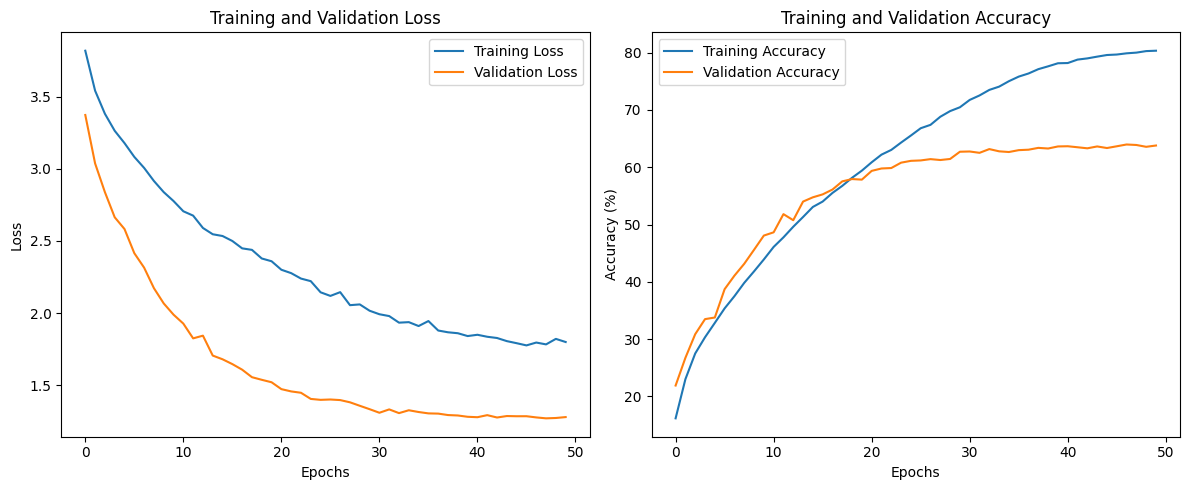

In [14]:
# Plot training and validation metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
# Load the best model
model.load_state_dict(torch.load('/kaggle/input/scratch-cnn-tsinghua-dog-breed-detection/best_dog_breed_model.pth'))

# EVALUATION FUNCTIONS
def evaluate_model(model, test_loader, num_classes, class_names):
    """Evaluate the model and return metrics"""
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Store predictions and labels for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Calculate per-class accuracy
            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    overall_accuracy = 100 * correct / total
    print(f'Accuracy on the test set: {overall_accuracy:.2f}%')
    
    # Calculate per-class accuracy
    class_accuracy = [(i, 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0) 
                    for i in range(num_classes)]
    sorted_accuracy = sorted(class_accuracy, key=lambda x: x[1], reverse=True)
    
    print("\nTop 5 classes:")
    for i, acc in sorted_accuracy[:5]:
        print(f'Class {i} ({class_names[i]}): {acc:.2f}%')
    
    print("\nBottom 5 classes:")
    for i, acc in sorted_accuracy[-5:]:
        print(f'Class {i} ({class_names[i]}): {acc:.2f}%')
    
    return all_preds, all_labels, overall_accuracy, class_accuracy

/tmp/ipykernel_31/3847847796.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/scratch-cnn-tsinghua-dog-breed-detection/bes

In [16]:
# Evaluate the model immediately
all_preds, all_labels, overall_accuracy, class_accuracy = evaluate_model(
    model, val_loader, num_classes, full_dataset.classes
)

Evaluating: 100%|██████████| 441/441 [00:41<00:00, 10.53it/s]

Accuracy on the test set: 83.97%

Top 5 classes:
Class 29 (West_Highland_white_terrier): 97.50%
Class 125 (golden_retriever): 97.19%
Class 31 (dhole): 97.14%
Class 58 (Samoyed): 96.63%
Class 115 (Bichon_Frise): 96.39%

Bottom 5 classes:
Class 76 (collie): 46.15%
Class 12 (Staffordshire_bullterrier): 44.44%
Class 116 (standard_poodle): 22.39%
Class 114 (toy_poodle): 9.50%
Class 105 (Japanese_Spitzes): 1.79%


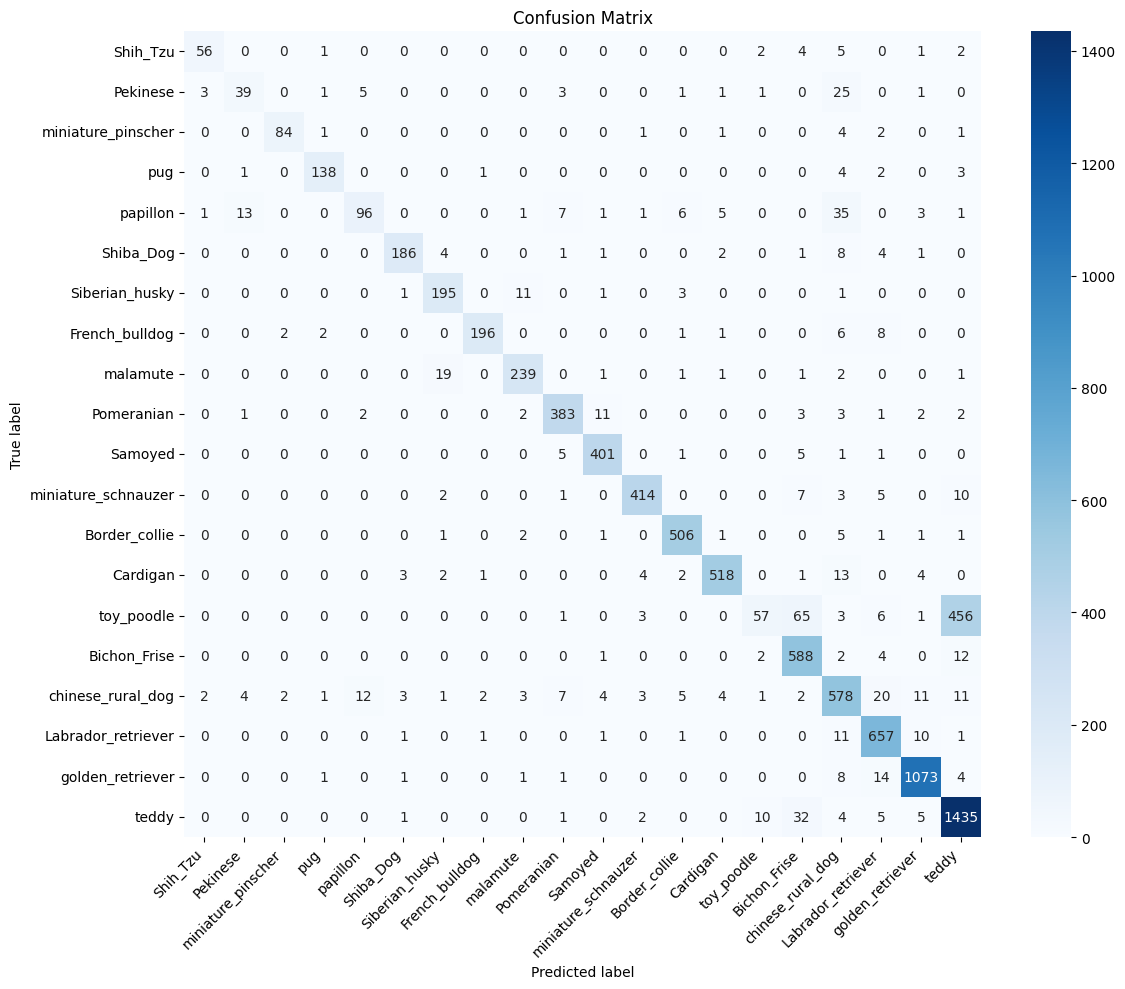

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names, max_classes=20):
    """Plot confusion matrix for model predictions"""
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # If there are many classes, select the top classes with most samples
    if len(class_names) > max_classes:
        # Sum samples per class
        class_counts = np.sum(cm, axis=1)
        # Get indices of top classes
        top_classes_idx = np.argsort(class_counts)[-max_classes:]
        # Filter confusion matrix to include only top classes
        cm = cm[top_classes_idx][:, top_classes_idx]
        # Filter class names
        plot_class_names = [class_names[i] for i in top_classes_idx]
    else:
        plot_class_names = class_names
    
    # Set up the figure
    plt.figure(figsize=(12, 10))
    
    # Create the heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=plot_class_names, 
                yticklabels=plot_class_names)
    
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

# Plot confusion matrix immediately
plot_confusion_matrix(all_labels, all_preds, full_dataset.classes)